In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from dataset import CoCoYoloDataset
from models import CameraYOLO
from utils import bbox_iou

import random

/opt/conda/envs/fusion/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ✅ 학습된 모델 불러오기
model = CameraYOLO(num_classes=80)  # 동일한 모델 구조 사용
model.load_state_dict(torch.load("../trained_ckpts/coco_trained_model_epoch_1.pth"))
model.eval()  # 모델을 평가 모드로 변경

CameraYOLO(
  (camera_stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): CSPBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bottlenecks): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
        )
        (1): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
        )
        (2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1

In [3]:
dataset = CoCoYoloDataset(data_root="../data/coco/", input_shape=(160, 120))
random_idx = random.randint(0, len(dataset))

image, labels = dataset[random_idx]
print(image.shape) # B, C, H, W

image = image.unsqueeze(0)
H, W = image.shape[2], image.shape[3]

torch.Size([3, 160, 120])


In [8]:
# ✅ 모델을 사용하여 예측 수행
with torch.no_grad():
    predictions = model(image)  # (1, N, num_classes + 5) 형태

# ✅ 예측 결과 파싱
predictions = predictions.squeeze(0).numpy()  # (N, num_classes + 5)
pred_boxes = predictions[:, :4]  # (N, 4) → x_center, y_center, width, height
print(pred_boxes.shape)
obj_confidences = predictions[:, 4]  # (N,) → Objectness Score
print(obj_confidences.shape)
class_probs = predictions[:, 5:]  # (N, num_classes) → 클래스 확률
print(class_probs.shape)

# ✅ 예측된 클래스 결정 (가장 높은 확률 가진 클래스 선택)
pred_class_ids = np.argmax(class_probs, axis=1)  # (N,)
print(pred_class_ids.shape)

# ✅ 특정 Confidence 이상인 박스만 필터링
confidence_threshold = 0.05
filtered_indices = obj_confidences > confidence_threshold
pred_boxes = pred_boxes[filtered_indices]
pred_class_ids = pred_class_ids[filtered_indices]
print(pred_boxes.shape)
print(pred_class_ids.shape)

(80, 4)
(80,)
(80, 80)
(80,)
(35, 4)
(35,)


In [9]:
print(labels.shape)

# ✅ GT 바운딩 박스 변환 (YOLO → 픽셀)
gt_boxes = np.array(labels)[:, 1:5]  # (M, 4)
gt_boxes[:, [0, 2]] *= W  # x_center, width 조정
gt_boxes[:, [1, 3]] *= H  # y_center, height 조정

print(labels[0].shape)

# ✅ 예측 바운딩 박스 변환 (YOLO → 픽셀)
pred_boxes[:, [0, 2]] *= W  # x_center, width 조정
pred_boxes[:, [1, 3]] *= H  # y_center, height 조정

print(pred_boxes.shape)


torch.Size([6, 5])
torch.Size([5])
(35, 4)


In [10]:
# ✅ GT와 예측 박스 간 IoU 계산
iou_matrix = bbox_iou(pred_boxes, gt_boxes)  # (N, M)
print(iou_matrix.shape)
best_iou, best_pred_idx = iou_matrix.max(axis=0)  # (M,)
print(best_iou)

matched_preds = pred_boxes[best_pred_idx]
matched_classes = pred_class_ids[best_pred_idx]

torch.Size([35, 6])
tensor([0.0000, 0.0000, 0.0000, 0.0401, 0.0000, 0.0340])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


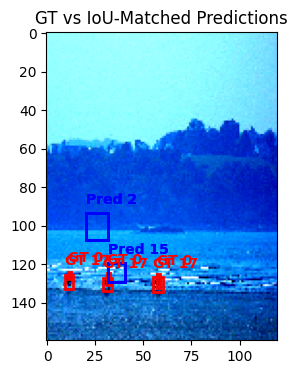

In [11]:
# ✅ 시각화
image = np.transpose(image.squeeze(0).numpy(), (1, 2, 0))  # (H, W, C)
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.imshow(image)

# 🔴 1️⃣ Ground Truth 박스 (빨간색)
for lbl in labels:
    class_id, x_center, y_center, width, height = lbl.numpy()
    x_min = (x_center - width / 2) * W
    y_min = (y_center - height / 2) * H
    box_w = width * W
    box_h = height * H

    rect = patches.Rectangle(
        (x_min, y_min), box_w, box_h, linewidth=2, edgecolor="red", facecolor="none"
    )
    ax.add_patch(rect)
    ax.text(x_min, y_min - 5, f"GT {int(class_id)}", color="red", fontsize=10, weight="bold")

# 🔵 2️⃣ IoU 높은 예측 박스 (파란색)
for i in range(len(matched_preds)):
    x_center, y_center, width, height = matched_preds[i]
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    box_w = width
    box_h = height

    rect = patches.Rectangle(
        (x_min, y_min), box_w, box_h, linewidth=2, edgecolor="blue", facecolor="none"
    )
    ax.add_patch(rect)
    ax.text(x_min, y_min - 5, f"Pred {int(matched_classes[i])}", color="blue", fontsize=10, weight="bold")

plt.title("GT vs IoU-Matched Predictions")
plt.show()